# Workspace for e-chemistry 
This is the workspace for e-chemistry for the B07 and A03 project. The workspace includes CP, CA and CV analysis tools, but they only work with a special file format.
The CP class can be used from the Elias Klemm group of the University of Stuttgart and the CA and CV project from the Kristina Tschulik group of the University of Bochum.

# Packages for the Analysis tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from scipy.optimize import curve_fit
#import scipy.integrate as spi
from sdRDM import DataModel
from tabulate import tabulate
from scipy.integrate import trapz


################################################################
#imports the Analysis tools from the subfolder functions. They are in a Py file called Analysis
from functions.Analysis import Analysis,ChronoPotentiometry,MultiChronoPotentiometry,ChronoAmperometry,MultiChronoAmperometry,CyclicVoltammetry


# Datamodel from Github
The following cell loads the Datamodel from Github and stores it in the variable lib. The working with a Datamodel is until now (05.05.2023) only a β-phase. In future versions the working with a Datamodel gets more features.

In [2]:

lib = DataModel.from_markdown("specifications/Electrochemistry.md")
#lib=DataModel.from_git(url="https://github.com/FAIRChemistry/datamodel-electrochemistry.git")

#https://github.com/FAIRChemistry/datamodel-electrochemistry.git

In [10]:
# path_program=os.getcwd()
# path_program

## Subfolders 
The following cell generates 2 subfolders called plots and data. You can use them to store your data and your plot. But it is not neccasary.

In [13]:
path_program=os.getcwd()
path_plots= path_program + "\plots"
os.makedirs(path_plots , exist_ok=True)
path_data= path_program + "\data"
os.makedirs(path_data , exist_ok=True)

# Change the style and parameter of the plots
The following cell is not needed only if you want to change some parameters of your plots

In [27]:
# plt.rcParams.update({
#     'figure.figsize': (6.4,4.8),     # 4:3 aspect ratio. You can change the figure size here
#     'font.size' : 12,                   # Set font size to 12pt
#     'axes.labelsize': 12,               # -> axis labels
#     'legend.fontsize': 12,              # -> legends
#     'font.family': 'serif',             # -> font family 
#     'text.usetex': True,              # Latex plot rendering. If True,your plots will be rendered with Latex. But this needs extra time for rendering
#      'text.latex.preamble':            # LaTeX preamble
#          r'\usepackage{mlmodern}'
#          #... more packages if needed
# })
####################

#plt.style.use('ggplot') # You can choose ure matplotlib style

# Analytic tools
## Analysis class 
The Analysis class includes a list of different reference potentials and a reference_difference function. This can be used to calculate the difference between two reference potentials. The reference_difference function needs 2 strings from the reference_list() as input. If the RHE scale is involved, a new windows pops up and you need also to enter the pH value.

In [5]:
Ana=Analysis()
Ana.reference_list()
Ana.reference_difference("Hg/HgO (1 M KOH)","RHE")

Reference              Potential (V)
-------------------  ---------------
SHE                            0
RHE                           -0.059
Calomel (sat. KCl)             0.241
Calomel (3.5 M KCl)            0.25
Calomel (1 M KCl)              0.28
Calomel (0.1 M KCl)            0.334
Ag/AgCl (sat. KCl)             0.199
Ag/AgCl (3.5 M KCl)            0.205
Hg/HgO (1 M KOH)               0.14
Hg/HgO (0.1 M KOH)             0.165
Fc/Fc+                         0.4


0.19920000000000002

# Input of your metadata
The following is an example how you store your information for a measurement. It is necessary for the plot and calculation functions. GSTATIC(Potentiostat).DTA is the filename which are in the subfolder data. If your file is somewhere else you need to give the full path as input. Windows makes a lot of problems in terms of working with paths. I highly recommend you to store your data in the data subfolder. Linux and MacOs should't make any problems. 

In [42]:
cp_sample1=lib.DatasetForPlots(filename="data/Cu12nm.DTA",reference="Hg/HgO",name="Cu 12 nm",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 10")


print your stored data with:


In [4]:
cp_sample1.__dict__

{'id': 'dataset_for_plots0',
 'filename': 'data/GSTATIC(Potentiostat).DTA',
 'reference': 'Ag/AgCl',
 'name': 'Sample1',
 'conducting_salt': 'KOH',
 'concentration': '0.1 M',
 'solvent': 'H$_2$O',
 'pH': 'pH 7',
 'scan_rate': None,
 'substrate': None}

# ChronoPotentiometry class/ ChronoPotentiometry(metadata,change_reference=False)
This class needs the metadata from above as input. You also have the choice to change your reference system by setting change_reference=True. A windows opens up and you need to give the reference difference as input and the new reference name. By doing this all your Potential values will be changed to the new system.

In [13]:
cp_normal=ChronoPotentiometry(cp_sample1)


In [40]:
cp_change_ref=ChronoPotentiometry(cp_sample1,change_referene=False)

The CP class has the following functions:
- quick_plot() -> shows all relevant data: $U$ vs time, $I$ vs. time and $U$ of the mess cell vs time. It is only to check if your data looks good or not
- plot(save=False,label=False) -> return a plot $U$ vs time. It can be saved by setting save=True. The x and y labels can also be changed with label=True
- end_value()
- end_value_fit()

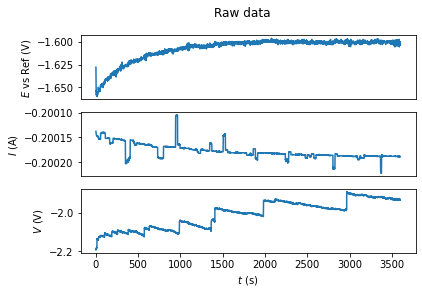

In [5]:
cp_normal.quick_plot()

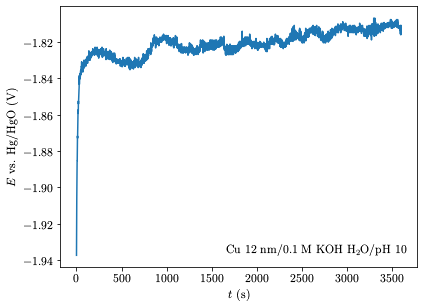

In [34]:
cp_normal.plot()
cp_change_ref.plot()
#change the axis labels:
#cp_normal.plot(label=True)
#save it with:
#cp_normal.plot(save=True)

determine the last potential with end_value(), which return the last value of your measurement or with end_value_fit() which determines it via a fit function.
The end_value_fit() can be better for oscillating measurements data

In [41]:
#cp_normal.end_value()
#cp_normal.end_value_fit()
cp_change_ref.end_value_fit()

c:\Users\dimi1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


-1.0892116666666372

# MultiChronoPotentiometry class/ MultiChronoPotentiometry([metadata,metadata2],change_reference=False)
The MultiCP class is for plotting multiple data in a single figure. It needs a list of metadata as input and has the same change_reference attribute. It only has a plot function with the same attributes (save=False and labels=False) like all plot functions.


In [7]:
cp_sample2=lib.DatasetForPlots(filename="data/Cu14nm.DTA",reference="Hg/HgO",name="Cu 14 nm",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 10")

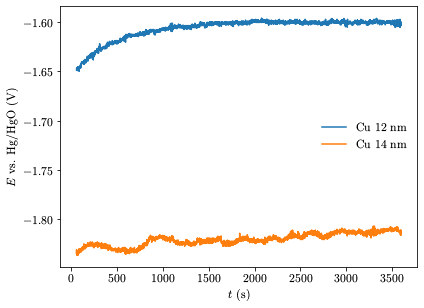

In [45]:
multicp=MultiChronoPotentiometry([cp_sample1,cp_sample2])
multicp.plot(save=False)

# ChronoAmperometry class/ ChronoAmperometry(metadata,current_density=False)
This class is very similar to the ChronoPotentiometry class it has the same input but another attribute current_density=False. By setting this on True you will be able to work with the current density instead of the current.

In [6]:
ca_sample1=lib.DatasetForPlots(filename="data/CA.csv",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7")
ca_sample1=lib.DatasetForPlots(filename="data/CA2.DTA",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7")


{'id': 'datasetforplots0',
 'filename': 'data/CA.csv',
 'reference': 'Ag/AgCl',
 'name': 'Sample1',
 'conducting_salt': 'KOH',
 'concentration': '0.1 M',
 'solvent': 'H$_2$O',
 'pH': 'pH 7',
 'scan_rate': None,
 'substrate': None}

In [11]:
ca=ChronoAmperometry(ca_sample1,current_density=True)

The CA class has the following functions:
- plot(save=False,label=False) -> return a plot $I$ vs time. It can be saved by setting save=True. The x and y labels can also be changed with label=True
- end_value()
- end_value_fit()

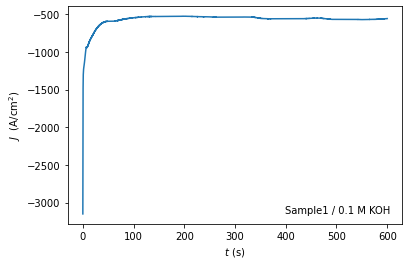

-558.688

In [17]:
ca.plot()
ca.end_value()
#ca.end_value_fit()

# MultiChronoAmperometry class/ MultiChronoAmperometry([metadata,metadata2],change_reference=False)
The MultiChronoAmperometry class is for plotting multiple data in a single figure. It needs a list of metadata as input and has the same current_density attribute. It only has a plot function with the same attributes (save=False and labels=False) like all plot functions. It is similar to the MultiChronoPotentiometry class.

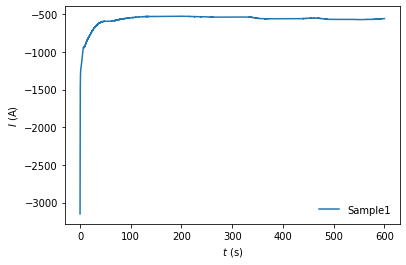

In [12]:
multica=MultiChronoAmperometry([ca_sample1])
multica.plot()

# CyclicVoltammetry class
## CyclicVoltammetry(metadata,[cycles]=None,change_reference=False,current_density=False)
The CyclicVoltammetry class is for Cyclic Voltammetry and needs also a metadata as input. An optional input are the cycles as a list. If you don't give a cycle as input then all cycles will be used. It has also the change_reference and current_density attributes as previously mentioned. The functions are:
- plot(legendposition(x,y),save=False,label=False)
- peaks(range=None) # By default it will be used the whole electrochemical windows, but you can put a range here.
- integration() # This integrates the for- and back cycle separately


In [5]:
cv_sample=lib.DatasetForPlots(filename="data/CV.csv",reference="Ag/AgCl",name="Sample1",conducting_salt="KOH",concentration="0.1 M",solvent="H$_2$O",pH="pH 7",substrate="Au",scan_rate="20 mV/s")

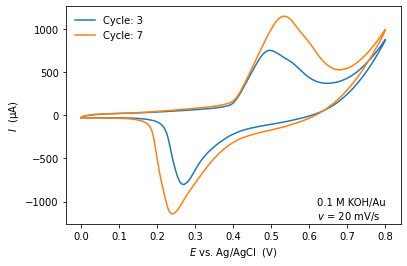

,Cycles,Integration Area
0,Cycle: 3,"(228.41508091625693, 55.65514063750714)"
1,Cycle: 7,"(315.68702839831326, 122.30824275336356)"


In [30]:
cv=CyclicVoltammetry(cv_sample,[3,7])
cv.plot()
cv.peaks()
cv.integration()

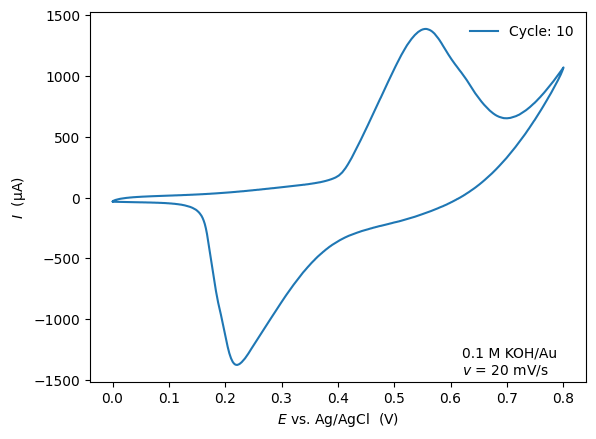

185.5927812587908 117.06505420619182


/tmp/ipykernel_3027/411339778.py:114: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  area1, error1 = integrate.quad(interp_func, 0.4,0.6)
/tmp/ipykernel_3027/411339778.py:115: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps 

In [14]:
from scipy import interpolate
from scipy.integrate import quad
from scipy import integrate

class CyclicVoltammetry(Analysis):
    def __init__(self,metadata,cycles=None,current_density=False,change_reference=False):
        self.df = pd.read_csv(metadata.filename,header=5,skipfooter=1,engine="python")
        self.total_cycles=len(self.df. columns) // 2
        self.all_cycles_list= [i for i in range(1,self.total_cycles+1)]
        self.solvent = metadata.solvent if metadata.solvent is not None else "MeCN"
        self.cycles= cycles if cycles is not None else self.all_cycles_list
        self.concentration = metadata.concentration if  metadata.concentration is not None else "0.1 M"
        self.conducting_salt =  metadata.conducting_salt if metadata.conducting_salt is not None else " KOH"
        self.substrate= metadata.substrate if metadata.substrate is not None else "Au"
        self.scan_rate= metadata.scan_rate if metadata.scan_rate is not None else "20 mV/s"
        self.reference = metadata.reference if metadata.reference is not None else "Ag/AgCl"
        self.name= metadata.name if metadata.name is not None else "" 
        self.E = ["E" for i in range(self.total_cycles)]
        self.I = ["I" for i in range(self.total_cycles)]
        self.df.columns = [name for pair in zip(self.E, self.I) for name in pair]
        self.num_cycles = int(self.df.shape[1] / 2)
        self.cycle_df = np.array_split(self.df, self.num_cycles, axis=1)
        self.cycles = [cycle-1 for cycle in self.cycles]
        if change_reference:
            delta_E=float(input("Enter the reference differnce: "))
            self.reference= input("Enter the reference name: ")
            for df in self.cycle_df:
                df['E'] = df['E'] + delta_E
        self.xlabel= f"$E$ vs. {self.reference}  (V)"
        self.ylabel= r"$I$  ($\mathrm{\mu}$A)" ### \textmu if latex rendering
        if current_density:
            A=float(input("Enter the WE area:"))
            J_unit= input("Enter the unit of your current density (Use $ symbols for exponent eg. A/cm$^2$ ): ")
            self.df["I"] = self.df["I"] / A
            self.ylabel= f"$J$  ({J_unit}) "
            for df in self.cycle_df:
                df['I'] = df['I'] / A
        #pass
    def plot(self,xy=None,save=False,label=False):
        xy= xy if xy is not None else (0.75,.02)
        fig, ax=plt.subplots()
        xlabel=self.xlabel
        ylabel=self.ylabel
        if label:
            xlabel= input("enter new xlabel: ")
            ylabel= input(r"enter new ylabel: ")
        ax.annotate(f"{self.concentration} {self.conducting_salt}/{self.substrate}\n$v$ = {self.scan_rate}", xy=xy, xycoords="axes fraction")
        for i in self.cycles: 
            ax.plot(self.cycle_df[i]["E"],self.cycle_df[i]["I"],label="Cycle: {}".format(i+1))
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.legend(loc="best",frameon=False)
        plt.show()

        if save:
            plotname=input("Enter the name of the plot: ")
            fig.savefig(plotname,bbox_inches='tight')
    def peaks(self,range=None):
        E_min=[]
        E_max=[]
        E_hwp=[]
        Cycles=[]
        I_max=[]
        I_min=[]
        I_vertex_list=[]
        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        range= range if range is not None else (x_min,x_max) 
        for i in self.cycles:
            Cycles.append("Cycle: {}".format(i+1))
            indices = np.where((self.cycle_df[i]["E"] >= range[0]) & (self.cycle_df[i]["E"] <= range[1]))[0]
            max_index = indices[np.argmax(self.cycle_df[i]["I"][indices])]
            pot_at_max = self.cycle_df[i]["E"][max_index]
            current_at_max = self.cycle_df[i]["I"][max_index]
            min_index = indices[np.argmin(self.cycle_df[i]["I"][indices])]
            pot_at_min = self.cycle_df[i]["E"][min_index]
            current_at_min = self.cycle_df[i]["I"][min_index]
            max_E= np.argmax(self.cycle_df[i]["E"])
            min_E= np.argmin(self.cycle_df[i]["E"])
            I_at_max_E=self.cycle_df[i]["I"][max_E]
            I_at_min_E=self.cycle_df[i]["I"][min_E]
            I_start=self.cycle_df[i]["I"][0]
            if self.cycle_df[0]["E"][0]< self.cycle_df[0]["E"][10]:
                I_vertex=I_at_max_E-I_start
            else:
                I_vertex=I_at_min_E-I_start
            E_max.append(pot_at_max)
            E_min.append(pot_at_min)
            E_hwp.append((pot_at_max+pot_at_min)/2 )
            I_min.append(current_at_min)
            I_max.append(current_at_max)
            I_vertex_list.append(I_vertex)
            df = pd.DataFrame(list(zip(Cycles,E_min,E_max,I_min,I_max,E_hwp,I_vertex_list)), columns=["Cycles",'E min','E max',"I min","I max","E1/2","I_vertex"])   
        return  df   
    def integration(self,range=None):
        Cycles=[]
        Integral=[]
        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        range= range if range is not None else (x_min,x_max)
        for i in self.cycles:
            Cycles.append("Cycle: {}".format(i+1)) 
            df=self.cycle_df[i]
            half= len(df)//2
            df1=df.iloc[:half,:]
            df2=df.iloc[half:,:]
            interp_func = interpolate.interp1d(df1["E"],df1["I"])
            interp_func2 = interpolate.interp1d(df2["E"],-df2["I"])
            #plt.plot(df1["E"],df1["I"])
            #plt.plot(df2["E"],df2["I"])
            # indices = np.where((df1["E"] >= range[0]) & (df1["E"] <= range[1]))[0]
            # indices2 = np.where((df2["E"] >= range[0]) & (df2["E"] <= range[1]))[0]
            # area cant be with indices2 I dont know why
            area1, error1 = integrate.quad(interp_func, 0.4,0.6)
            area2, error2 = integrate.quad(interp_func2, 0.2,0.3)
            # area1 = np.trapz(df1["I"], df1["E"])
            # area2 = np.trapz(df2["I"], df2["E"])
            """ das untere ist falsch"""
            # area1 = np.trapz(df1["E"], df1["I"])
            # area2 = np.trapz(df2["E"], df2["I"])
            print(area1,area2)
            # area1 = trapz(df1['I'][indices],df1['E'][indices])
            # area2 = trapz(df2['I'],df2['E'])   
   
            #Integral.append((area1,area2))
        #     dataframe = pd.DataFrame(zip(Cycles,Integral), columns=["Cycles","Integration Area"])
        # return dataframe
cv=CyclicVoltammetry(cv_sample,[10])
cv.plot()
cv.peaks()
cv.integration()

In [14]:
#https://pypi.org/project/EC-MS/

Flächeninhalt: 5.874999999999999
